# Manipal Weather Predictor

In this notebook we are going to go with simple RNN followed by GRU and LSTMs to Predict Manipal's weather.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Loading the Dataset

We'll now proceed to load the dataset by downloading it using google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

meta = pd.read_csv("/content/drive/MyDrive/manipal_atmospherics_df.csv", nrows=1)
data = pd.read_csv("/content/drive/MyDrive/manipal_atmospherics_df.csv", skiprows=3, parse_dates=['time'])

data.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,time,temperature_2m_mean (°C),precipitation_sum (mm),shortwave_radiation_sum (MJ/m²),apparent_temperature_mean (°C),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),sunshine_duration (s),wind_direction_10m_dominant (°),pressure_msl_mean (hPa),cloud_cover_mean (%),dew_point_2m_mean (°C),soil_moisture_0_to_7cm_mean (m³/m³)
0,2011-01-04,24.7,0.0,19.69,27.7,17.4,4.09,36798.94,325,1009.7,70,20.4,0.278
1,2011-01-05,25.4,0.0,17.77,28.5,15.9,3.91,36494.80,309,1008.7,85,20.4,0.276
2,2011-01-06,26.2,0.0,19.31,28.8,18.4,4.45,36924.74,319,1008.7,61,19.4,0.273
3,2011-01-07,25.6,0.0,20.26,28.0,15.6,4.52,37417.72,178,1008.6,12,18.6,0.270
4,2011-01-08,25.2,0.0,20.29,28.2,15.1,4.38,37473.21,313,1008.3,29,20.0,0.268


## Data Understanding

We'll now plot some graphs in an attempt to ananlyze and undersatnd the data.

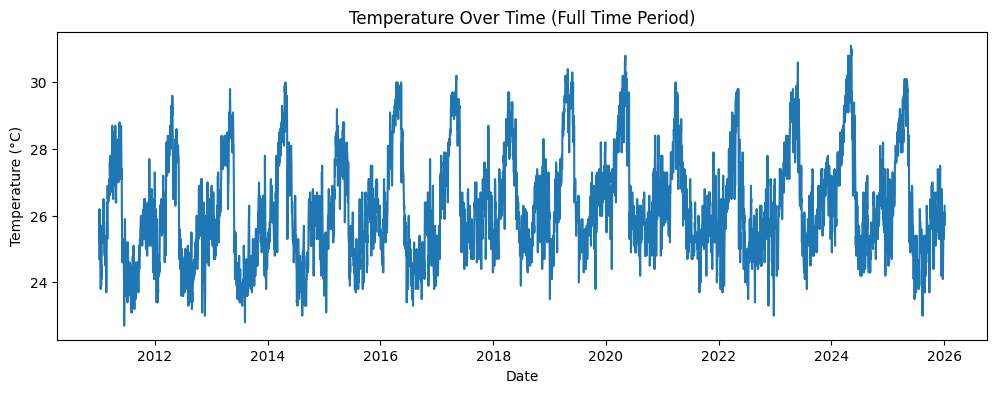

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(data["time"], data["temperature_2m_mean (°C)"])
plt.title("Temperature Over Time (Full Time Period)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

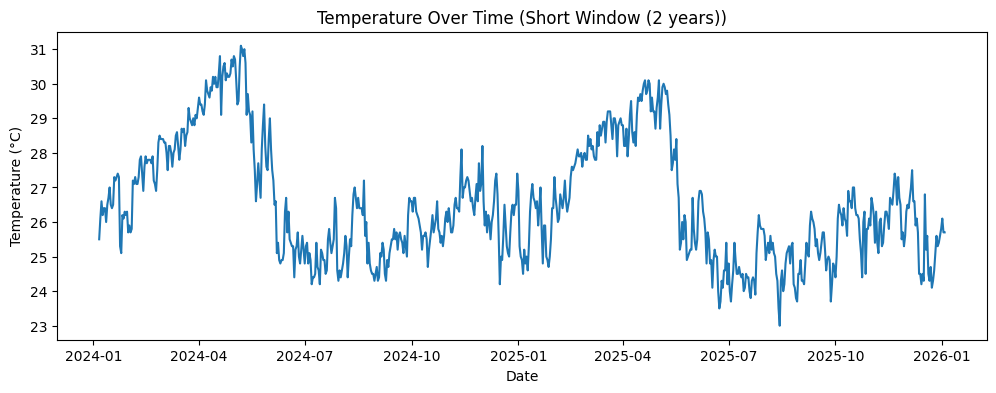

In [ ]:
subset = data.iloc[-730:-1]

plt.figure(figsize=(12,4))
plt.plot(subset["time"], subset["temperature_2m_mean (°C)"])
plt.title("Temperature Over Time (Short Window (2 years))")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

Based on thsese graphs we can assume we can identify seasonal **Summer** and **Monsoon** cycles, with the temperature gradually rising from January to may, and temperature stabalising from June to December.

## Data Split and Preprocessing

We will now proceed to split the data and preprocess it. We'll scaker the data using MinMaxScaler and create sliding windows to train RNN.

In [ ]:
train_data = data[data["time"] < "2025-01-04"]
test_data = data[data["time"] >= "2-25-01-04"]

In [ ]:
scaler = MinMaxScaler()

train_temp = scaler.fit_transform(train_data[["temperature_2m_mean (°C)"]])

test_temp = scaler.transform(test_data[["temperature_2m_mean (°C)"]])

In [ ]:
def create_sequences(data, window_size):
  X, y = [], []
  for i in range(len(data) - window_size):
    X.append(data[i:i+window_size])
    y.append(data[i+window_size])
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 14

X_train, y_train = create_sequences(train_temp, WINDOW_SIZE)
X_test, y_test = create_sequences(test_temp, WINDOW_SIZE)

print(X_train.shape, y_train.shape)

(5100, 14, 1) (5100, 1)


## Creating the Univariate Model

We'll now proceed to create the univariate model.

In [ ]:
model = Sequential([
    SimpleRNN(32, input_shape=(WINDOW_SIZE, 1), activation="tanh"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=16,
    verbose=1
)

Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0326 - val_loss: 0.0056
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0041 - val_loss: 0.0050
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 5/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 6/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 7/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 8/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 9/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 10/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 11/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 12/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

### Evaluating the univariate model

In [ ]:
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"Baseline RNN MAE:  {mae:.2f} °C")
print(f"Baseline RNN RMSE: {rmse:.2f} °C")

Baseline RNN MAE:  0.39 °C
Baseline RNN RMSE: 0.51 °C


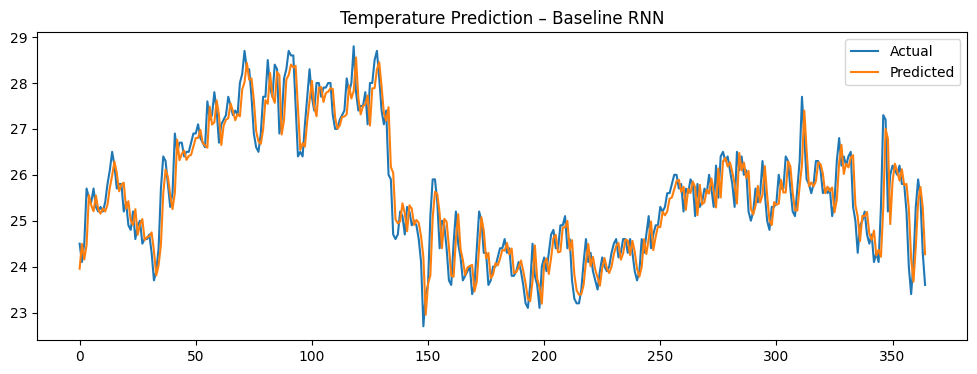

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(y_test_inv[:365], label="Actual")
plt.plot(y_pred_inv[:365], label="Predicted")
plt.legend()
plt.title("Temperature Prediction – Baseline RNN")
plt.show()

Our model does a pretty good for a simple RNN with pretty low MAE and RMSE>

## Univariate on Precipitation

Let's test the same model but on precipitaion instead.

In [ ]:
scaler = MinMaxScaler()

train_precip = scaler.fit_transform(train_data[["precipitation_sum (mm)"]])

test_precip = scaler.transform(test_data[["precipitation_sum (mm)"]])

In [ ]:
WINDOW_SIZE = 14

X_train, y_train = create_sequences(train_precip, WINDOW_SIZE)
X_test, y_test = create_sequences(test_precip, WINDOW_SIZE)

print(X_train.shape, y_train.shape)

(5100, 14, 1) (5100, 1)


In [ ]:
model = Sequential([
    SimpleRNN(32, input_shape=(WINDOW_SIZE, 1), activation="tanh"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=16,
    verbose=1
)

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0056 - val_loss: 0.0060
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039 - val_loss: 0.0057
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0042 - val_loss: 0.0058
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0045 - val_loss: 0.0060
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037 - val_loss: 0.0058
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039 - val_loss: 0.0057
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0040 - val_loss: 0.0056
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036 - val_loss: 0.0058
Epoch 9/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0041 - val_loss: 0.0056
Epoch 10/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - val_loss: 0.0056


In [ ]:
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"Baseline RNN MAE:  {mae:.2f} mm")
print(f"Baseline RNN RMSE: {rmse:.2f} mm")

Baseline RNN MAE:  6.07 mm
Baseline RNN RMSE: 11.01 mm


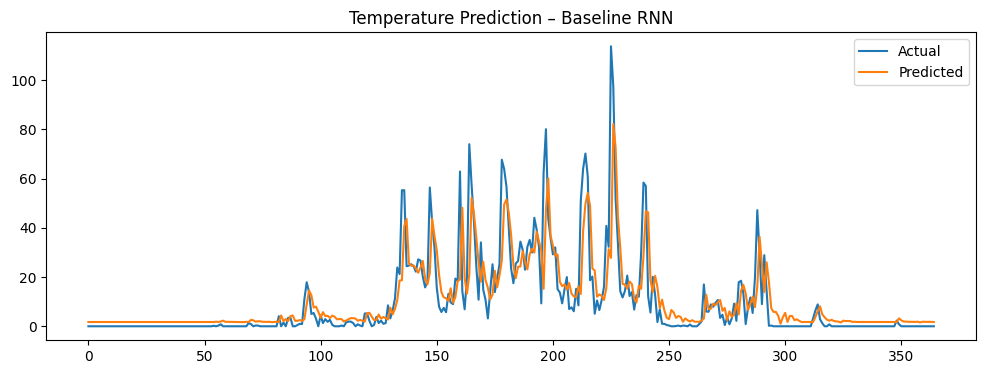

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(y_test_inv[:365], label="Actual")
plt.plot(y_pred_inv[:365], label="Predicted")
plt.legend()
plt.title("Precipitation Prediction – Baseline RNN")
plt.show()

Acceptable RME and MSE, now let's check with multivariate.

## Multivariate Model

We'll now proceed to create the multivariate model. For this, we'll use all the available metrics to add data except wind direction (since it is not a recurring parameter and is cyclic).

In [ ]:
FEATURES = [
    "shortwave_radiation_sum (MJ/m²)",
    "apparent_temperature_mean (°C)",
    "wind_speed_10m_max (km/h)",
    "pressure_msl_mean (hPa)",
    "cloud_cover_mean (%)",
    "dew_point_2m_mean (°C)",
    "sunshine_duration (s)",
    "et0_fao_evapotranspiration (mm)",
    "temperature_2m_mean (°C)",
    "precipitation_sum (mm)"
]

TARGETS = [
    "temperature_2m_mean (°C)",
    "precipitation_sum (mm)"
]

### Scaling the variables

In [ ]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = X_scaler.fit_transform(train_data[FEATURES])
X_test = X_scaler.fit_transform(test_data[FEATURES])

y_train = y_scaler.fit_transform(train_data[TARGETS])
y_test = y_scaler.fit_transform(test_data[TARGETS])

### Updated Sequences Function

In [ ]:
def new_create_sequences(X, Y, window_size):
  x, y = [], []
  for i in range(len(X) - window_size):
    x.append(X[i:i+window_size])
    y.append(Y[i+window_size])
  return np.array(x), np.array(y)

In [ ]:
WINDOW = 14

X_train_seq, y_train_seq = new_create_sequences(X_train, y_train, WINDOW)
X_test_seq, y_test_seq = new_create_sequences(X_test, y_test, WINDOW)


### GRU Model Building

We'll use a GRU since it will be faster.

In [ ]:
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(WINDOW, X_train.shape[1])),
    GRU(32),
    Dense(2)
])

model.compile(optimizer="adam", loss="mse")

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 14, 64)         │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,066 (94.01 KB)

 Trainable params: 24,066 (94.01 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]
)

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0160 - val_loss: 0.0065
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0048 - val_loss: 0.0057
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0051
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 9/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037 - val_loss: 0.0047
Epoch 10/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 11/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 12/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/s

### Evaluation

In [ ]:
pred = model.predict(X_test_seq)

y_test_inv = y_scaler.inverse_transform(y_test_seq)
pred_inv   = y_scaler.inverse_transform(pred)


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
def metrics(true, pred):
    return {
        "MAE": mean_absolute_error(true, pred),
        "RMSE": np.sqrt(mean_squared_error(true, pred))
    }

temp_metrics = metrics(y_test_inv[:,0], pred_inv[:,0])
prec_metrics = metrics(y_test_inv[:,1], pred_inv[:,1])

temp_metrics, prec_metrics


({'MAE': 0.37919229967359475, 'RMSE': np.float64(0.498582551086667)},
 {'MAE': 5.731732941852754, 'RMSE': np.float64(10.617929728724548)})

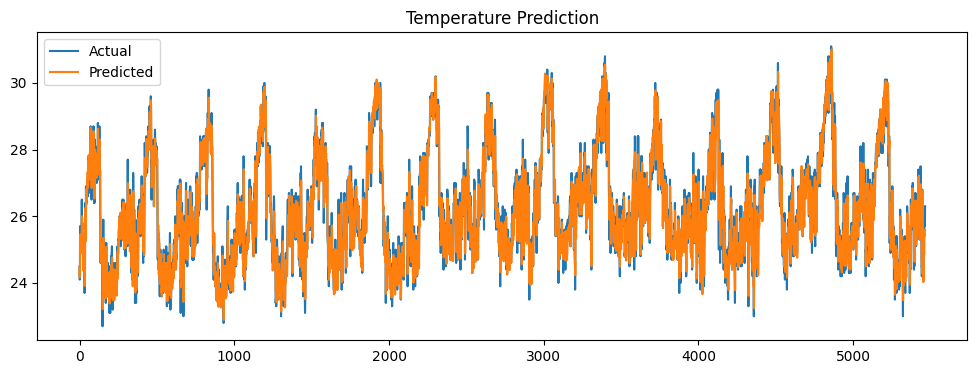

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(y_test_inv[:,0], label="Actual")
plt.plot(pred_inv[:,0], label="Predicted")
plt.title("Temperature Prediction")
plt.legend()
plt.show()


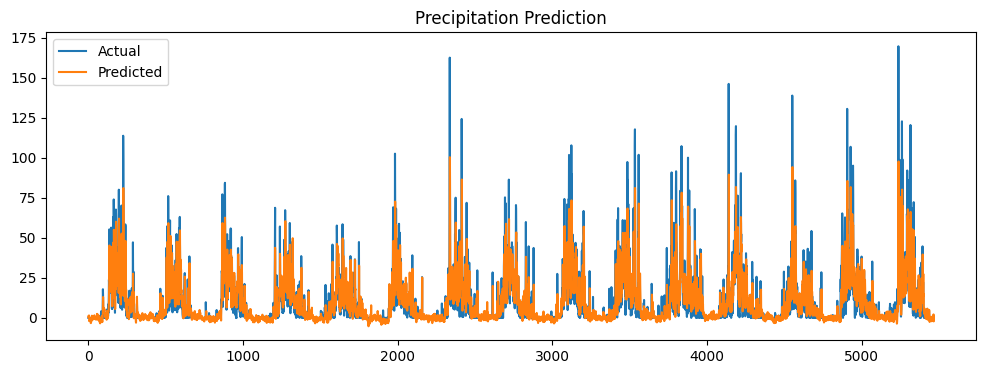

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(y_test_inv[:,1], label="Actual")
plt.plot(pred_inv[:,1], label="Predicted")
plt.title("Precipitation Prediction")
plt.legend()
plt.show()


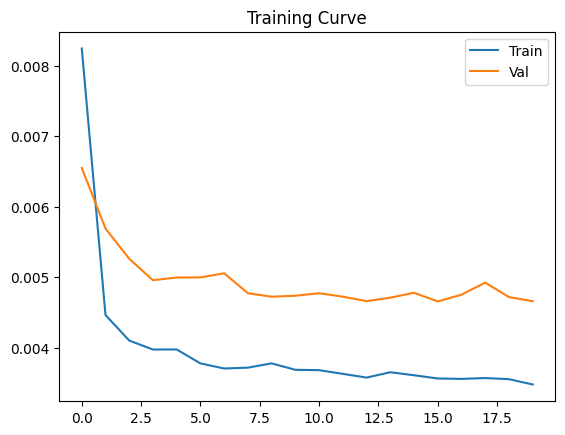

In [ ]:
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.legend()
plt.title("Training Curve")
plt.show()


# Final Results and Analysis

| Model | Inputs | Temp MAE (°C) | Temp RMSE (°C) | Precip MAE (mm) | Precip RMSE (mm)
|----|----|----|----|----|----|
| Univariate RNN | Temperature | 0.39 | 0.51 | 6.07 | 11.01 |
| Multivariate GRU | All available variables | 0.37 | 0.49 | 5.73 | 10.61|

When compared to the RNN baseline, the GRU multivariate model produced slightly better results, which are more impactful in case of precipitaion since it is affected more by the other atmospheric factors.

Overall, the results show that GRU model is actually good for forecasting.